In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import warnings
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
warnings.simplefilter('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

In [2]:
PCOS_inf = pd.read_csv('./../PCOS_infertility.csv')
PCOS_woinf = pd.read_excel('./../PCOS_data_without_infertility.xlsx', sheet_name="Full_new")

data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes={'','_y'},how='left')

data =data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', 
                 '  I   beta-HCG(mIU/mL)_y', 'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

data.columns = [col.strip() for col in data.columns]

X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1)
y=data["PCOS (Y/N)"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
random_forest = RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=23, n_estimators=100)
pipe = Pipeline(steps=(['ss', ss], ['random_forest', random_forest]))

In [5]:
pipe

Pipeline(memory=None,
         steps=(['ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)],
                ['random_forest',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=8, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2,
                                        min_samples_split=23,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False)]),
 

In [6]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ['random_forest',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=8, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2,
                                        min_samples_split=23,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False)]],
 

In [7]:
acc_rf_clf_train = round(pipe.score(X_train, y_train)*100,2) 
acc_rf_clf_test = round(pipe.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_rf_clf_train))
print("Testing Accuracy: % {}".format(acc_rf_clf_test))

Training Accuracy: % 95.14
Testing Accuracy: % 90.83


In [8]:
pipe_prob_y_pred = pipe.predict_proba(X_test)
pipe_fpr, pipe_tpr, pipe_threshold = roc_curve(y_test, pipe_prob_y_pred[:,1])
pipe_auc = auc(pipe_fpr, pipe_tpr)

[]

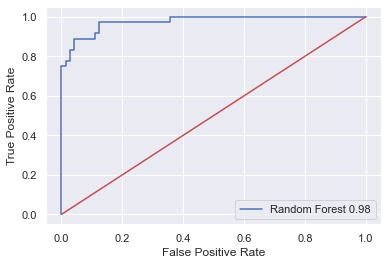

In [9]:
sns.set(style="darkgrid")
plt.plot(pipe_fpr, pipe_tpr, label = 'Random Forest %0.2f'%pipe_auc)
plt.plot([0,1],[0,1],'r-')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot()

In [10]:
roc_auc_score(y_test, pipe_prob_y_pred[:,1])

0.976027397260274

In [11]:
# with ovo

roc_auc_score(y_test, pipe_prob_y_pred[:,1], average = 'macro', multi_class = 'ovo')

0.976027397260274

In [12]:
from sklearn.metrics import cohen_kappa_score
pred_pipe = pipe.predict(X_test)
cohen_kappa_score(y_test, pred_pipe)

0.780241935483871

In [13]:
pred_pipe = pipe.predict(X_test)
from sklearn.metrics import classification_report
classi_report = classification_report(y_test, pred_pipe)
print(classi_report)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94        73
           1       0.96      0.75      0.84        36

    accuracy                           0.91       109
   macro avg       0.93      0.87      0.89       109
weighted avg       0.91      0.91      0.90       109

